# Feature Engineering & Hypothesis Testing Notebook

This notebook focuses on generating new features from the cleaned dataset and testing hypotheses based on domain knowledge and EDA insights.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load cleaned training data
train = pd.read_csv('..\\data\\cleaned_data\\train_cleaned.csv')
test = pd.read_csv('..\\data\\cleaned_data\\test_cleaned.csv')

# Quick check
print(f'Train shape: {train.shape}, Test shape: {test.shape}')
train.head()

Train shape: (103904, 23), Test shape: (25976, 23)


,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Dep_Arr_Time_Convenient,Ease_of_Online_booking,Gate_Location,...,Inflight_Entertainment,On_board_Service,Leg_Room_Service,Baggage_Handling,Checkin_Service,Inflight_Service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18,0
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6,0
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0,1
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9,0
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0,1


## 1. Feature Engineering
We'll create new features to enhance predictive power based on domain knowledge.

In [26]:
# --- 1. Delay Features ---
# Create delay categories
train['Departure_Delay_Category'] = pd.cut(
    train['Departure_Delay_in_Minutes'],
    bins=[-1, 0, 15, 60, np.inf],
    labels=['On-time', 'Minor', 'Moderate', 'Severe']
)
test['Departure_Delay_Category'] = pd.cut(
    test['Departure_Delay_in_Minutes'],
    bins=[-1, 0, 15, 60, np.inf],
    labels=['On-time', 'Minor', 'Moderate', 'Severe']
)

train['Arrival_Delay_Category'] = pd.cut(
    train['Arrival_Delay_in_Minutes'],
    bins=[-1, 0, 15, 60, np.inf],
    labels=['On-time', 'Minor', 'Moderate', 'Severe']
)
test['Arrival_Delay_Category'] = pd.cut(
    test['Arrival_Delay_in_Minutes'],
    bins=[-1, 0, 15, 60, np.inf],
    labels=['On-time', 'Minor', 'Moderate', 'Severe']
)


#### 📌 Create Combined Service Scores
The dataset contains many service-related ratings—such as seat comfort, food, cleanliness, entertainment, and online boarding—that are all measured on the same 0–5 scale. These features are highly correlated, meaning passengers tend to rate multiple services similarly. Using each one separately adds redundancy and can reduce model performance due to multicollinearity.

Creating a combined Service Score gives a single, clearer measure of the passenger’s overall service experience. It captures the general quality of service better than any individual rating and often becomes a stronger predictor of satisfaction. It also simplifies hypothesis testing by allowing me to analyze the effect of overall service quality in one step instead of many.

For business insights, a single service score is easier to interpret and communicate—higher scores simply mean better service and higher satisfaction.

In [27]:

# --- 2. Service Ratings Aggregate ---
service_cols = ['Inflight_wifi_service', 'Online_Boarding', 'Seat_Comfort', 'Cleanliness', 
                'Inflight_Entertainment', 'Checkin_Service', 'Food_and_Drink', 'Inflight_Service',
                'Ease_of_Online_booking', 'Gate_Location', 'Leg_Room_Service', 'Baggage_Handling']

# Total service score
train['Total_Service_Score'] = train[service_cols].sum(axis=1)
test['Total_Service_Score'] = test[service_cols].sum(axis=1)

# Average service score
train['Average_Service_Score'] = train[service_cols].mean(axis=1)
test['Average_Service_Score'] = test[service_cols].mean(axis=1)

# High-level rating flag
train['High_Service_Flag'] = np.where(train['Average_Service_Score'] >= 4, 1, 0)
test['High_Service_Flag'] = np.where(test['Average_Service_Score'] >= 4, 1, 0)

## 2. Hypothesis Testing
We'll test some hypotheses from EDA using statistical tests.

### Hypothesis 1: Business travelers are more satisfied than Leisure travelers
Test Used: Independent two-sample t-test

Reason: Compares the mean satisfaction between two independent groups (business vs leisure). Satisfaction is numerical (0/1), so t-test measures whether the difference in averages is statistically significant.

In [28]:
business_satisfaction = train[train['Type_of_Travel']=='Business travel']['satisfaction']
leisure_satisfaction = train[train['Type_of_Travel']=='Personal Travel']['satisfaction']

t_stat, p_val = stats.ttest_ind(business_satisfaction, leisure_satisfaction)
print(f'T-Test: t={t_stat:.3f}, p={p_val:.4f}')
if p_val < 0.05:
    print('Reject null hypothesis: Business travelers satisfaction differs significantly from Personal travelers')
else:
    print('Fail to reject null hypothesis')

T-Test: t=161.975, p=0.0000
Reject null hypothesis: Business travelers satisfaction differs significantly from Personal travelers


### Hypothesis 2: Loyalty effect

Test Used: Pearson correlation / Linear regression

Reason: Both variables are numerical (Average_Service_Score and satisfaction). Pearson correlation checks for linear relationship, showing if higher service scores associate with higher satisfaction.

In [29]:

contingency_table = pd.crosstab(train['Customer_Type'], train['satisfaction'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f'Chi-square Test: chi2={chi2:.3f}, p={p:.4f}')
if p < 0.05:
    print('Reject null hypothesis: Customer type is associated with satisfaction')
else:
    print('Fail to reject null hypothesis')

Chi-square Test: chi2=3657.281, p=0.0000
Reject null hypothesis: Customer type is associated with satisfaction


### Hypothesis 3: High service score correlates with satisfaction

Test Used: Chi-square test of independence

Reason: Both variables are categorical (Customer_Type = Loyal/Disloyal, satisfaction = 0/1). Chi-square tests whether satisfaction distribution is independent of customer type.

In [30]:
high_service = train[train['High_Service_Flag']==1]['satisfaction']
low_service = train[train['High_Service_Flag']==0]['satisfaction']

t_stat, p_val = stats.ttest_ind(high_service, low_service)
print(f'T-Test (High vs Low Service): t={t_stat:.3f}, p={p_val:.4f}')
if p_val < 0.05:
    print('Reject null hypothesis: High service rating impacts satisfaction')
else:
    print('Fail to reject null hypothesis')

T-Test (High vs Low Service): t=133.932, p=0.0000
Reject null hypothesis: High service rating impacts satisfaction


### Hypothesis 4: Travel Class vs Satisfaction

Question: Does the class of travel (Economy, Business, or Premium Economy) affect passenger satisfaction?

Reasoning for test selection:

- Travel Class is categorical with 3 levels.

- Satisfaction is binary (0/1).

- This is a comparison of proportions across multiple independent groups, so a Chi-Square Test of Independence is appropriate.

In [31]:
# Hypothesis 4: Travel Class vs Satisfaction
from scipy.stats import chi2_contingency

# Create a contingency table
class_satisfaction = pd.crosstab(train['Class'], train['satisfaction'])

print("Contingency Table:\n", class_satisfaction)

# Perform Chi-Square Test
chi2, p, dof, expected = chi2_contingency(class_satisfaction)
print(f"\nChi-Square Statistic: {chi2:.3f}")
print(f"P-value: {p:.5f}")

if p < 0.05:
    print("Result: Reject H0 → Travel class affects satisfaction")
else:
    print("Result: Fail to reject H0 → No significant effect of class on satisfaction")


Contingency Table:
 satisfaction      0      1
Class                     
Business      15185  34480
Eco           38044   8701
Eco Plus       5650   1844

Chi-Square Statistic: 26471.863
P-value: 0.00000
Result: Reject H0 → Travel class affects satisfaction


### Hypothesis 5: Flight Delays vs Satisfaction

Question: Do longer departure or arrival delays decrease passenger satisfaction?

Reasoning for test selection:

- Departure_Delay_in_Minutes and Arrival_Delay_in_Minutes are continuous numeric variables.

- Satisfaction is binary.

- To compare means of delays between satisfied and dissatisfied passengers, an independent samples t-test is appropriate (if assumptions are met).

In [32]:
# Hypothesis 5: Delays vs Satisfaction
from scipy.stats import ttest_ind

# Separate delays by satisfaction
satisfied_delay = train[train['satisfaction'] == 1]['Departure_Delay_in_Minutes']
dissatisfied_delay = train[train['satisfaction'] == 0]['Departure_Delay_in_Minutes']

# Perform independent t-test
t_stat, p_val = ttest_ind(satisfied_delay, dissatisfied_delay, equal_var=False)  # Welch's t-test

print(f"Departure Delay t-statistic: {t_stat:.3f}, P-value: {p_val:.5f}")

if p_val < 0.05:
    print("Result: Reject H0 → Delays significantly affect satisfaction")
else:
    print("Result: Fail to reject H0 → No significant effect of delays on satisfaction")


Departure Delay t-statistic: -16.575, P-value: 0.00000
Result: Reject H0 → Delays significantly affect satisfaction


## 3. Visualizing Feature Effects
I'll visualize some of the engineered features vs satisfaction.

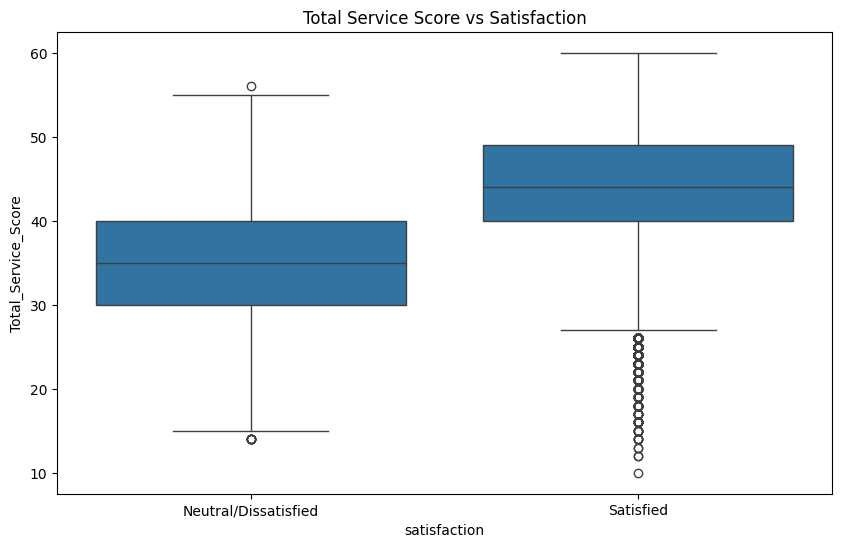

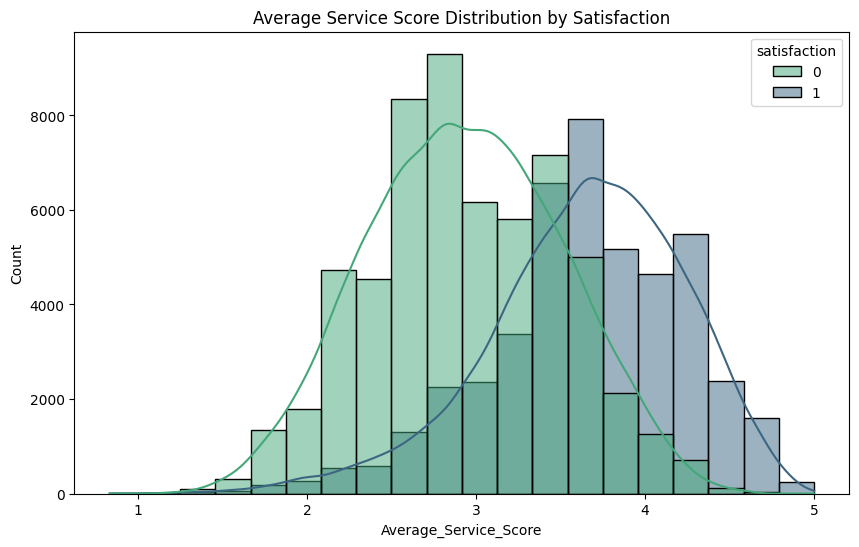

In [33]:
# Plot Total Service Score vs Satisfaction
plt.figure(figsize=(10,6))
sns.boxplot(data=train, x='satisfaction', y='Total_Service_Score')
plt.xticks([0,1], ['Neutral/Dissatisfied', 'Satisfied'])
plt.title('Total Service Score vs Satisfaction')
plt.show()

# Plot Average Service Score distribution
plt.figure(figsize=(10,6))
sns.histplot(data=train, x='Average_Service_Score', hue='satisfaction', bins=20, kde=True, palette=['#44a779','#3c6682'])
plt.title('Average Service Score Distribution by Satisfaction')
plt.show()

#### Total Service Score vs Satisfaction:

- The boxplot shows that passengers who are satisfied generally have higher total service scores compared to neutral or dissatisfied passengers.

- The median service score for satisfied passengers is clearly above that of the neutral/dissatisfied group.

- There is more variability in the satisfied group, with some high-end outliers, while the neutral/dissatisfied group has a tighter, lower range of scores.

- Overall, higher service scores strongly correlate with increased passenger satisfaction.

## 4. Saving Engineered Features
Save the datasets with new features for modeling.

In [34]:
train.to_csv('..\\data\\cleaned_data\\train_engineered.csv', index=False)
test.to_csv('..\\data\\cleaned_data\\test_engineered.csv', index=False)
print('Engineered datasets saved successfully.')

Engineered datasets saved successfully.
